# Sightlines

We demonstrate the gridding of selected sightlines with `cygrid`. This can be particularly useful if you have some high-resolution data such as QSO absorption spectra and want to get accurate foreground values from a dataset with lower angular resolution.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`healpy`](http://healpy.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [13]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as pl

import healpy as hp
from astropy.io import fits

import cygrid

## Create dummy data

The properties of the map are given by the ordering and the nside of the map. For more details, check the paper by [Gorski et al. (2005)](http://adsabs.harvard.edu/abs/2005ApJ...622..759G).

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

The `data` are just random draws from the standard normal distribution. For the `weights`, we choose uniform weighting. The coordinates can be easily calculated with `healpy`.

In [4]:
# data and weights
input_data = np.random.randn(NPIX)

# coordinates
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
lons = np.rad2deg(phi)
lats = 90. - np.rad2deg(theta)

A quick look confirms that our `data` looks just as expected. 

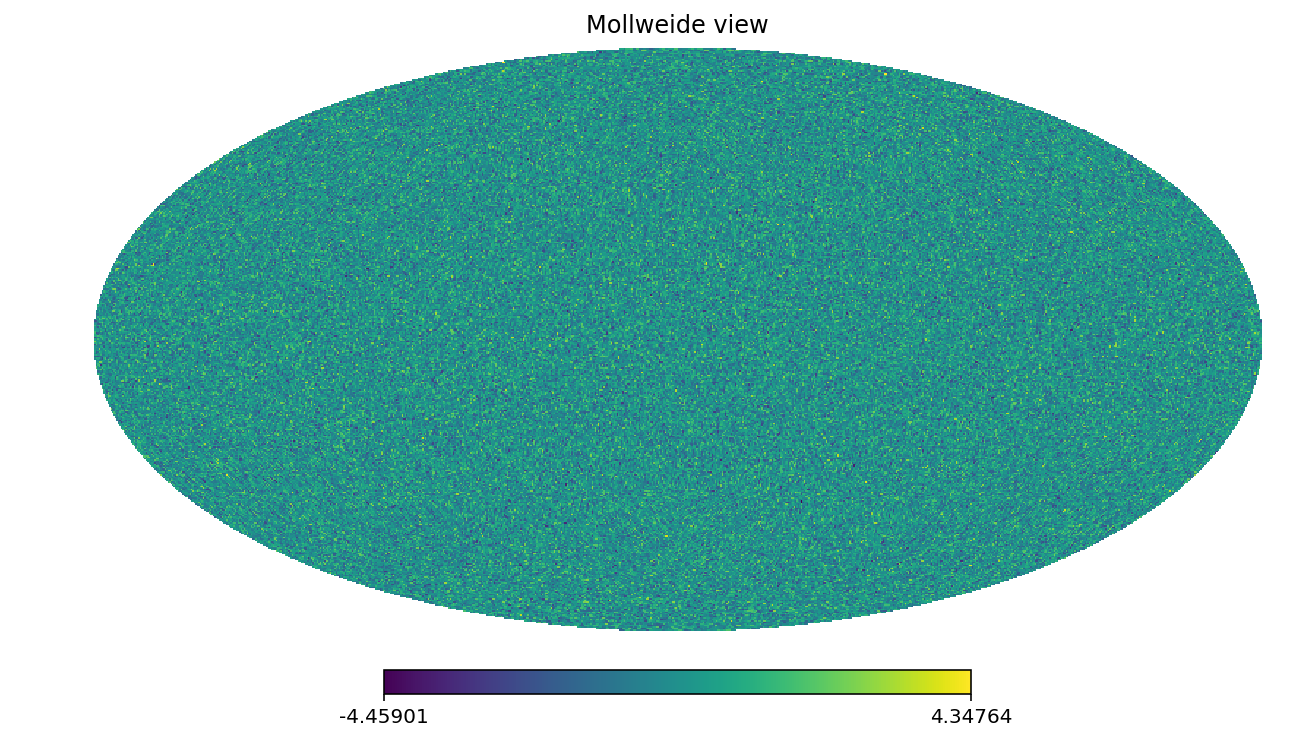

In [5]:
hp.mollview(input_data)

## Gridding

We generate a couple of random $(l, b)$-pairs as target sightlines. The ranges here are $0 < l < 360$ and $-90 < b < 90$.

In [7]:
target_lons = np.random.random(5) * 360.
target_lats = np.random.random(5) * 180. - 90.
print('glon, glat')
print(np.column_stack((target_lons, target_lats)))

glon, glat
[[   6.00122142   11.84855679]
 [ 184.07314372   23.75509205]
 [ 201.60338772  -28.24009668]
 [ 261.20765605   -8.84926119]
 [ 203.17426094  -35.78925584]]


We initiate the gridder by specifying the target sightlines. The third argument gives the length of the spectral axis, owing to the design of `cygrid` for spectroscopic data. We simply add a degenerate, empty axis of length 1 here.

In [8]:
gridder = cygrid.SlGrid(target_lons, target_lats, 1)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [9]:
kernelsize_fwhm = 1. # 1 degree
kernelsize_sigma = kernelsize_fwhm / 2.355 # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the coordinates and the data. Note that we need to add an artifical third axis to the `input_data`.

In [10]:
gridder.grid(lons, lats, input_data[:, None])

To get the gridded data, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [11]:
sightlines = gridder.get_datacube().squeeze()

Finally, we get a list of our gridded sightlines within the chosen aperture.

In [12]:
print('glon, glat, value')
print(np.column_stack((target_lons, target_lats, sightlines)))

glon, glat, value
[[  6.00122142e+00   1.18485568e+01  -4.74593759e-01]
 [  1.84073144e+02   2.37550921e+01   1.91500913e-02]
 [  2.01603388e+02  -2.82400967e+01  -2.48699263e-01]
 [  2.61207656e+02  -8.84926119e+00  -4.01399404e-01]
 [  2.03174261e+02  -3.57892558e+01   5.67693293e-01]]
